In [1]:
# Import all necessity functions for Machine Learning
import sys
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import zipfile
import cv2
import os
import random
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, silhouette_score

# Import all necessity functions for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, LSTM, GRU, RNN, Flatten, AvgPool2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization, Dropout, LeakyReLU, ELU, PReLU
from tensorflow.keras.activations import tanh, relu, sigmoid, softmax, swish
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam, Adamax, Nadam
from tensorflow.keras.initializers import HeNormal, HeUniform, GlorotNormal, GlorotUniform
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, hinge, MSE, MAE, Huber
import keras.utils as image

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the dataset
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print("X_train shape # {} ".format(X_train.shape),'\n')
print("y_train shape # {} ".format(y_train.shape),'\n')
print("X_test shape  # {} ".format(X_test.shape),'\n')
print("y_test shape  # {} ".format(y_test.shape))

X_train shape # (60000, 28, 28)  

y_train shape # (60000,)  

X_test shape  # (10000, 28, 28)  

y_test shape  # (10000,) 


In [4]:
"""
    Convert this shape into (60000, 1, 28, 28) that is acceptable for PyTorch
"""
X_train = np.expand_dims(X_train, axis = 1)
X_test  = np.expand_dims(X_test, axis = 1)

print("X_train shape # {} ".format(X_train.shape),'\n')
print("X_test shape  # {} ".format(X_test.shape))

X_train shape # (60000, 1, 28, 28)  

X_test shape  # (10000, 1, 28, 28) 


#####Display some of the images

In [5]:
IMAGES = X_train[0:20]
IMAGES.reshape(-1, 28, 28).shape

(20, 28, 28)

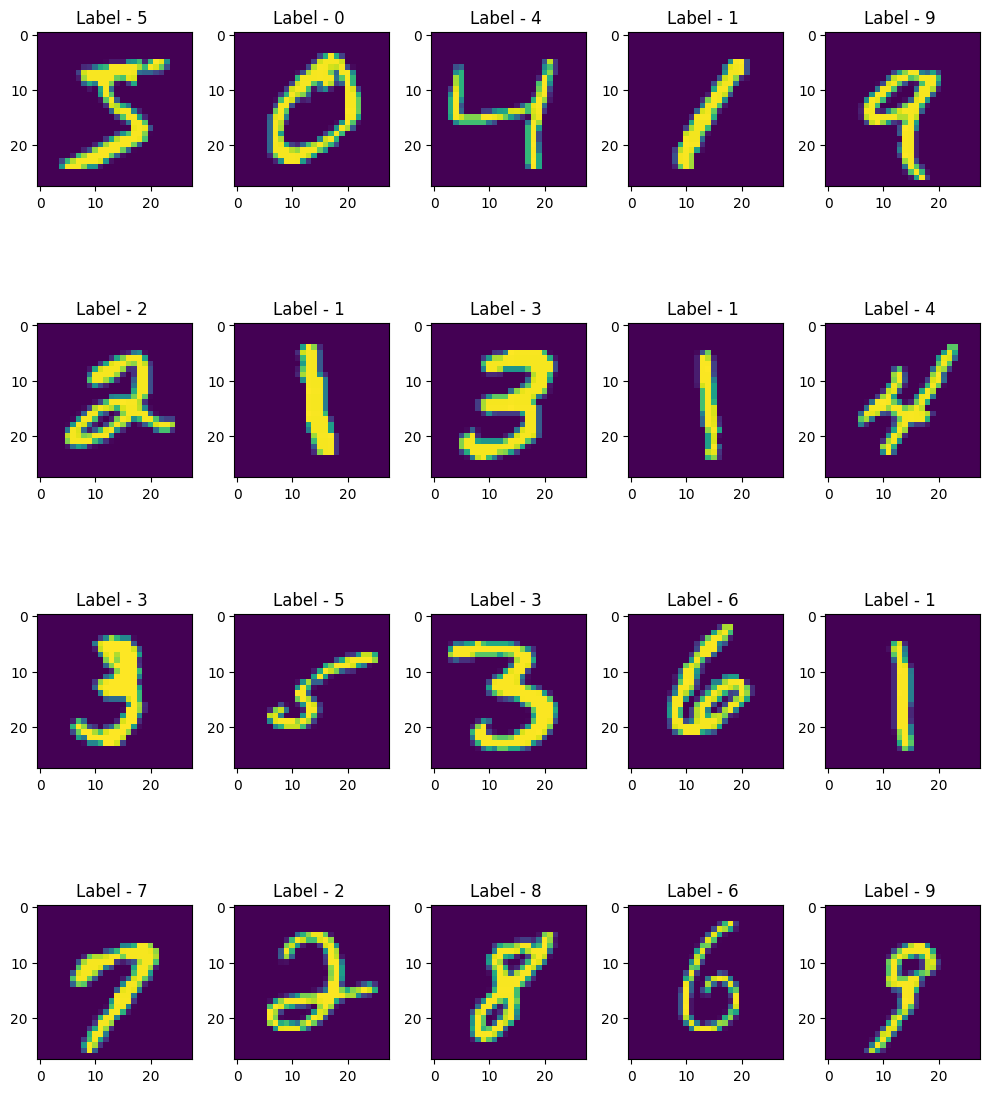

In [6]:
IMAGES = X_train[0:20]
IMAGES = IMAGES.reshape(-1, 28, 28)
LABELS = y_train[0:20]

plt.figure(figsize = (10, 12))
for index, image in enumerate(IMAGES):
  plt.subplot(4, 5, index + 1)
  plt.title('Label - {} '.format(LABELS[index]))
  plt.imshow(image)

plt.tight_layout()
plt.show()

#####Call the DataLoader and split the dataset with batch_size # 64

In [7]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models

In [8]:
X_train = X_train/255
X_test  = X_test/255

print("Normalozation is completed.")

Normalozation is completed.


In [9]:
BATCH_SIZE = 128

X_train = torch.tensor(data = X_train, dtype = torch.float32)
y_train = torch.tensor(data = y_train, dtype = torch.float32)

X_test  = torch.tensor(data = X_test, dtype = torch.float32)
y_test  = torch.tensor(data = y_test, dtype = torch.float32)

train_loader = DataLoader(dataset = list(zip(X_train, y_train)), batch_size = BATCH_SIZE, shuffle = True)
test_loader  = DataLoader(dataset = list(zip(X_test, y_test)), batch_size = BATCH_SIZE, shuffle = True)

print("batch_size of train # {} ".format(train_loader.batch_size),'\n')
print("batch_size of test  # {} ".format(test_loader.batch_size),'\n'*2)

train_data, train_label = next(iter(train_loader))
test_data, test_label   = next(iter(test_loader))

print("train data shape with batch_size  # {} ".format(train_data.shape),'\n')
print("train label shape with batch_size # {} ".format(train_label.shape),'\n')

print("test data shape with batch_size  # {} ".format(test_data.shape),'\n')
print("test label shape with batch_size # {} ".format(test_label.shape),'\n'*2)

"""
    Checking the Iteration in ONE EPOCH
"""
SHAPE = 0
ITERATE = 0

for data, label in test_loader:
  SHAPE+= data.shape[0]
  ITERATE+= 1
print("SHAPE   # {} ".format(SHAPE),'\n')
print("ITERATE # {} ".format(ITERATE))

batch_size of train # 128  

batch_size of test  # 128  


train data shape with batch_size  # torch.Size([128, 1, 28, 28])  

train label shape with batch_size # torch.Size([128])  

test data shape with batch_size  # torch.Size([128, 1, 28, 28])  

test label shape with batch_size # torch.Size([128])  


SHAPE   # 10000  

ITERATE # 79 


#####Model building using Functional API Type

In [10]:
"""
    Create a class named DigitClassifier that would take TWO parameters
      1. input_channel: Define whether the image is RGB or Gray
      2. output_channel: Define how many class in target that we need to be predicted

    Call the super function that will inherit all the necessity methods and functions of parent class
"""
class DigitClassifier(nn.Module):
  def __init__(self, input_dimension = None, output_dimension = None):
    super().__init__()

    """
        Create a left most convolutional sequential layer with a couple of parameters
          1. in_channels : Define the image channel that will take input_dimension
          2. out_channels : Define the output neurons
          3. kernel_size : Define the output of feature map
          4. stride : Define how much the kernel will move TOP BOTTOM LEFT RIGHT
          5. padding : Define whether the feature map would be equivalent to the orginal image or not

        Activation : Define the information would be passed to next neurons or not
        MaxPool2d  : Define the down-sampling on top of the feature map so that we can prevent the overfitting
        Dropout : Define to prevent the overfitting problem

        Input-Shape: (28 * 28) * 1 ==> (14 * 14) * 32
    """
    self.leftConv1 = nn.Sequential(
        nn.Conv2d(in_channels = input_dimension,\
                  out_channels= 32,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2),
        nn.Dropout(p = 0.2)
    )

    """
        Create a middle most convolutional sequential layer 1 with a couple of parameters
          1. in_channels : Define the image channel that will take input_dimension
          2. out_channels : Define the output neurons
          3. kernel_size : Define the output of feature map
          4. stride : Define how much the kernel will move TOP BOTTOM LEFT RIGHT
          5. padding : Define whether the feature map would be equivalent to the orginal image or not

        Activation : Define the information would be passed to next neurons or not
        MaxPool2d  : Define the down-sampling on top of the feature map so that we can prevent the overfitting
        Dropout : Define to prevent the overfitting problem

        Input-Shape: (28 * 28) * 1 ==> (14 * 14) * 64
    """
    self.middleConv1 = nn.Sequential(
        nn.Conv2d(in_channels = input_dimension,\
                  out_channels = 64,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),\
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2),\
        nn.Dropout(p = 0.2)
    )
    """
        Create a middle most convolutional sequential layer 2 with a couple of parameters
          1. in_channels : Define the image channel that will take input_dimension
          2. out_channels : Define the output neurons
          3. kernel_size : Define the output of feature map
          4. stride : Define how much the kernel will move TOP BOTTOM LEFT RIGHT
          5. padding : Define whether the feature map would be equivalent to the orginal image or not

        Activation : Define the information would be passed to next neurons or not
        MaxPool2d  : Define the down-sampling on top of the feature map so that we can prevent the overfitting
        Dropout : Define to prevent the overfitting problem

        Input-Shape: (14 * 14) * 64 ==> (7 * 7) * 32
    """
    self.middleConv2 = nn.Sequential(
        nn.Conv2d(in_channels = 64,\
                  out_channels = 32,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),\
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2),\
        nn.Dropout(p = 0.2)
    )
    """
        Create a right most convolutional sequential layer 1 with a couple of parameters
          1. in_channels : Define the image channel that will take input_dimension
          2. out_channels : Define the output neurons
          3. kernel_size : Define the output of feature map
          4. stride : Define how much the kernel will move TOP BOTTOM LEFT RIGHT
          5. padding : Define whether the feature map would be equivalent to the orginal image or not

        Activation : Define the information would be passed to next neurons or not
        MaxPool2d  : Define the down-sampling on top of the feature map so that we can prevent the overfitting
        Dropout : Define to prevent the overfitting problem

        Input-Shape: (28 * 28) * 1 ==> (14 * 14) * 128
    """
    self.rightConv1 = nn.Sequential(
        nn.Conv2d(in_channels = input_dimension,\
                  out_channels = 128,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),\
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2),\
        nn.Dropout(p = 0.4)
    )
    """
        Create a right most convolutional sequential layer 2 with a couple of parameters
          1. in_channels : Define the image channel that will take input_dimension
          2. out_channels : Define the output neurons
          3. kernel_size : Define the output of feature map
          4. stride : Define how much the kernel will move TOP BOTTOM LEFT RIGHT
          5. padding : Define whether the feature map would be equivalent to the orginal image or not

        Activation : Define the information would be passed to next neurons or not
        MaxPool2d  : Define the down-sampling on top of the feature map so that we can prevent the overfitting
        Dropout : Define to prevent the overfitting problem

        Input-Shape: (14 * 14) * 128 ==> (7 * 7) * 64
    """
    self.rightConv2 = nn.Sequential(
        nn.Conv2d(in_channels = 128,\
                  out_channels = 64,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),\
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2),\
        nn.Dropout(p = 0.4)
    )
    """
        Create a right most convolutional sequential layer 3 with a couple of parameters
          1. in_channels : Define the image channel that will take input_dimension
          2. out_channels : Define the output neurons
          3. kernel_size : Define the output of feature map
          4. stride : Define how much the kernel will move TOP BOTTOM LEFT RIGHT
          5. padding : Define whether the feature map would be equivalent to the orginal image or not

        Activation : Define the information would be passed to next neurons or not
        MaxPool2d  : Define the down-sampling on top of the feature map so that we can prevent the overfitting
        Dropout : Define to prevent the overfitting problem

        Input-Shape: (7 * 7) * 64 ==> (3 * 3) * 32
    """
    self.rightConv3 = nn.Sequential(
        nn.Conv2d(in_channels = 64,\
                  out_channels = 32,\
                  kernel_size = 3,\
                  stride = 1,\
                  padding = 1),
        nn.ReLU(),\
        nn.MaxPool2d(kernel_size = 2,\
                     stride = 2),\
        nn.Dropout(p = 0.1)
    )
    """
        Create a Sequential Fully Connected Layer
          1. in_features : Define the input_dimension, in this case it will take from left, right, middle
          2. out_features: Define the next neurons with respect to the hidden layer
          3. Activation : ReLU
          4. Dropout: rate is 0.6 - to prevent the overfitting problem
    """
    self.fc1 = nn.Sequential(
        nn.Linear(in_features = 14 * 14 * 32 + 7 * 7 * 32 + 3 * 3 * 32, out_features = 128),
        nn.ReLU(),
        nn.Dropout(p = 0.5)
    )
    """
        Create second Sequential Fully Connected Layer
          1. in_features : Define the input_dimension: 512
          2. out_features: Define the next neurons with respect to the hidden layer
          3. Activation : ReLU
          4. Dropout: rate is 0.6 - to prevent the overfitting problem
    """
    self.fc2 = nn.Sequential(
        nn.Linear(in_features = 128, out_features = 64),
        nn.ReLU(),
        nn.Dropout(p = 0.2)
    )
    """
        Create output Sequential Fully Connected Layer
          1. in_features : Define the input_dimension: 128
          2. out_features: Define the next neurons with respect to the hidden layer
          3. Activation : ReLU
          4. Dropout: rate is 0.6 - to prevent the overfitting problem
    """
    self.outputLayer = nn.Sequential(
        nn.Linear(in_features = 64, out_features = output_dimension),
        nn.Softmax()
    )

  def forward(self, x):
    """
        Pass the inependent features to the convolutional layer
        Do the Flatten operation so that we can do the concat operation
    """
    x1 = self.leftConv1(x)
    x1 = x1.reshape(x1.shape[0], -1)

    """
        Pass the inependent features to the convolutional layer
        Do the Flatten operation so that we can do the concat operation
    """
    x2 = self.middleConv1(x)
    x2 = self.middleConv2(x2)
    x2 = x2.reshape(x2.shape[0], -1)

    """
        Pass the inependent features to the convolutional layer
        Do the Flatten operation so that we can do the concat operation
    """
    x3 = self.rightConv1(x)
    x3 = self.rightConv2(x3)
    x3 = self.rightConv3(x3)
    x3 = x3.reshape(x3.shape[0], -1)

    # Concat operation all three separate convolutional layer
    out = torch.concat((x1, x2, x3), dim = 1)

    out = self.fc1(out)

    out = self.fc2(out)

    out = self.outputLayer(out)

    return out

In [11]:
# Call the model
try:
  model = DigitClassifier(input_dimension = 1, output_dimension = 10)
except Exception as e:
  print(e.with_traceback())
else:
  print(model.parameters)

<bound method Module.parameters of DigitClassifier(
  (leftConv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (middleConv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (middleConv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (rightConv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3):

#####Gpu connect

In [12]:
from torch.cuda import is_available
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [13]:
# Connect model into GPU
model = model.to(device)
model

DigitClassifier(
  (leftConv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (middleConv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (middleConv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (rightConv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.4, inplace=False)
  )


In [14]:
#Print the summary of model
summary(model = model, input_size = X_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Dropout-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 28, 28]             640
              ReLU-6           [-1, 64, 28, 28]               0
         MaxPool2d-7           [-1, 64, 14, 14]               0
           Dropout-8           [-1, 64, 14, 14]               0
            Conv2d-9           [-1, 32, 14, 14]          18,464
             ReLU-10           [-1, 32, 14, 14]               0
        MaxPool2d-11             [-1, 32, 7, 7]               0
          Dropout-12             [-1, 32, 7, 7]               0
           Conv2d-13          [-1, 128, 28, 28]           1,280
             ReLU-14          [-1, 128,

#####Model architecture

In [15]:
!pip install torchviz

In [16]:
from torchviz import make_dot

plot_model = make_dot(model(X_train[0:64].to(device)))

plot_model.render("model_graph", format="png")

'model_graph.png'

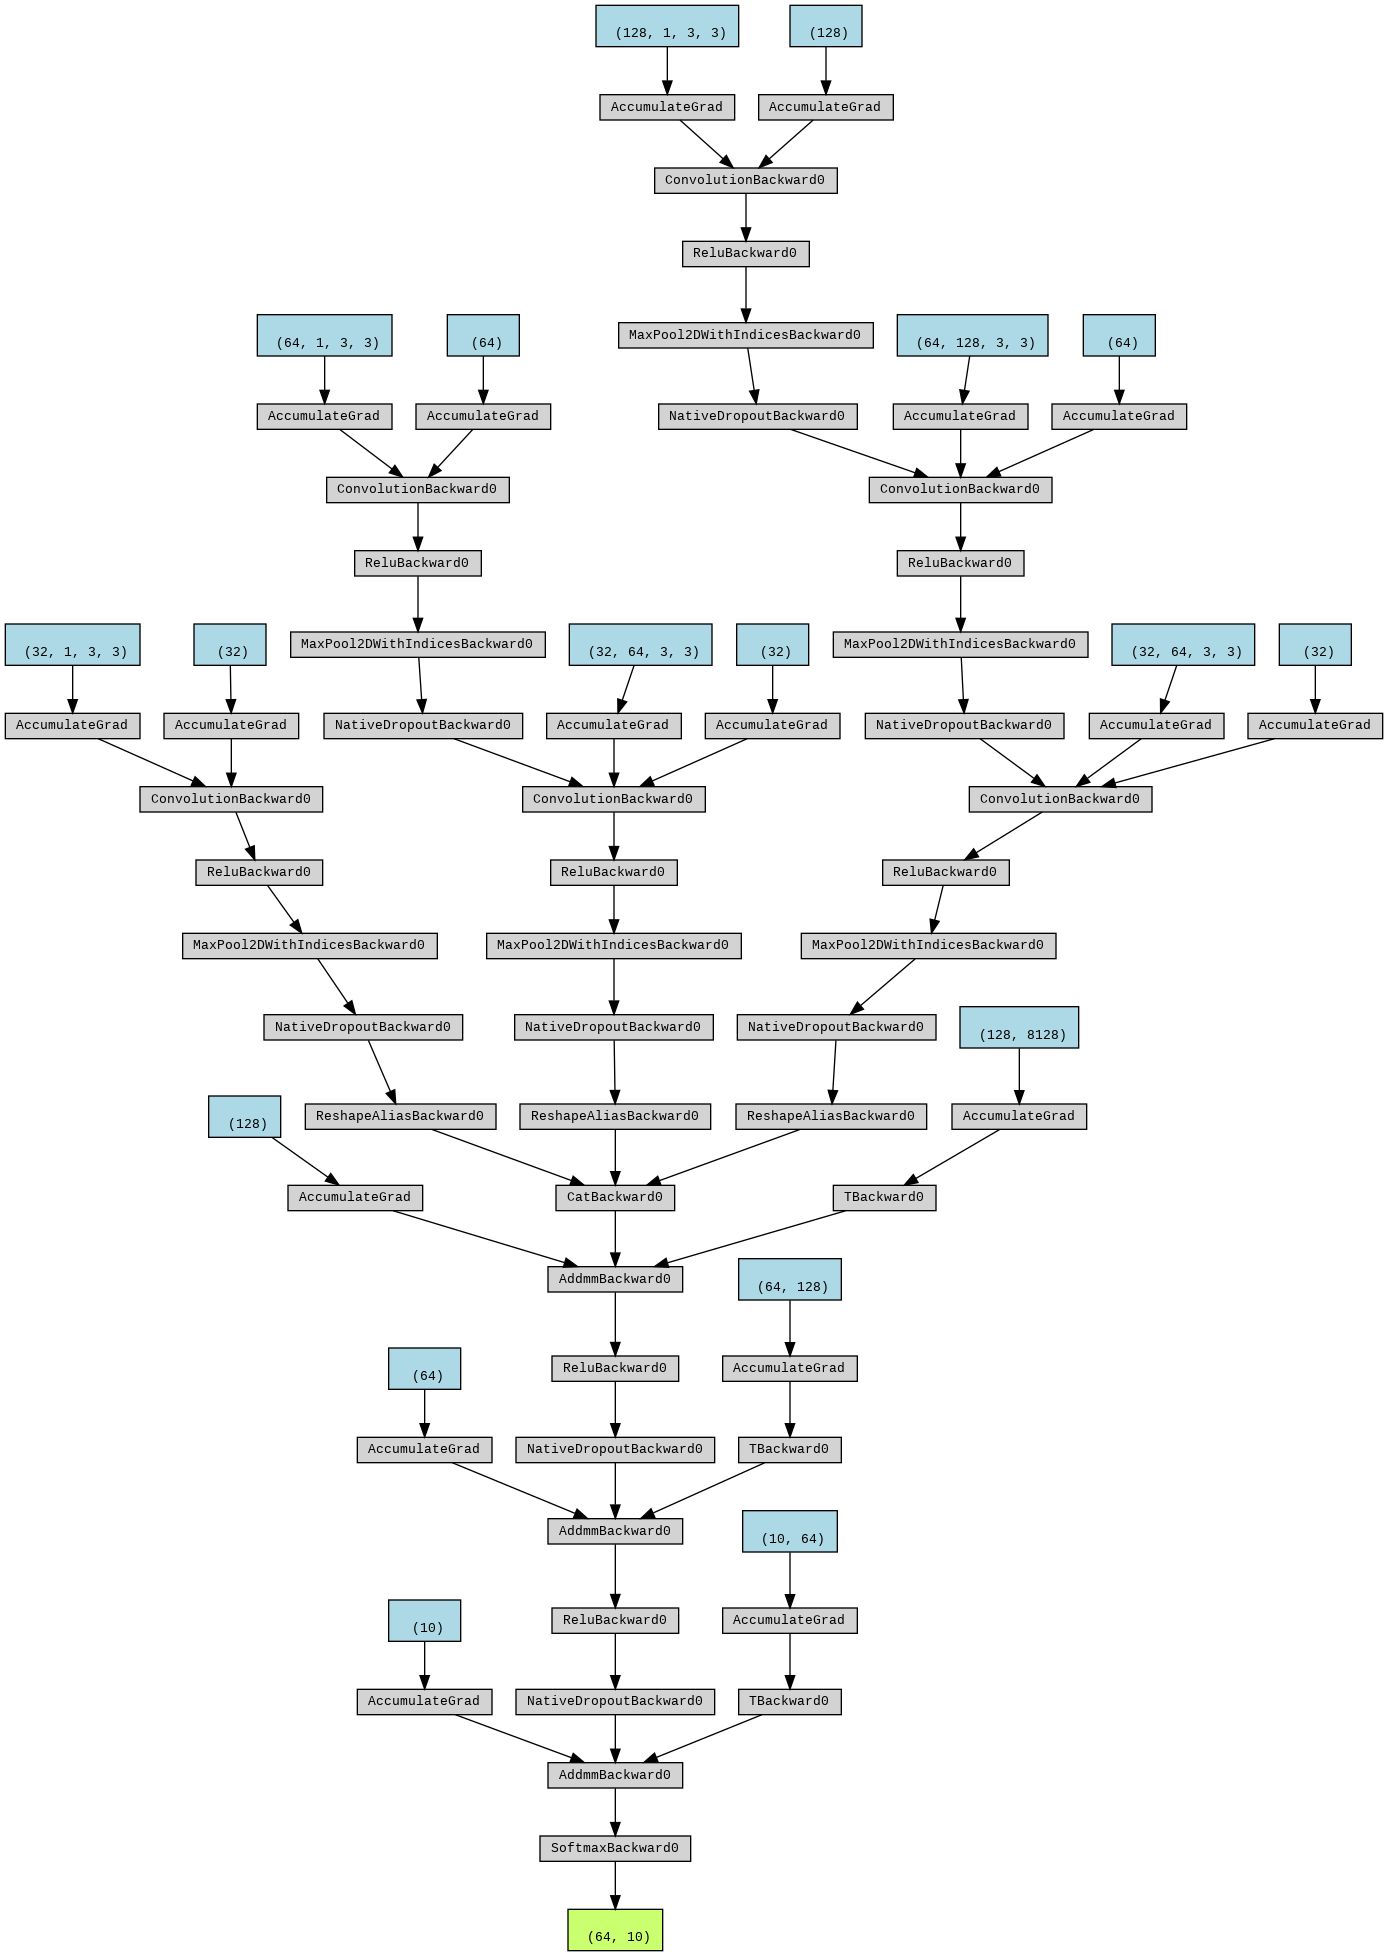

In [17]:
from IPython.display import display, Image
display(Image(data = '/content/model_graph.png'))

In [18]:
# Display all trainable parameters
total_trainable_parameters = 0
for name, params in model.named_parameters():
  if params.requires_grad == True:
    print("Layer name # {} & total trainable parameters # {} ".format(name, params.numel()))
    total_trainable_parameters+= total_trainable_parameters + params.numel()

print("\n")
print("Total Trainable Parameters # {} ".format(total_trainable_parameters))

Layer name # leftConv1.0.weight & total trainable parameters # 288 
Layer name # leftConv1.0.bias & total trainable parameters # 32 
Layer name # middleConv1.0.weight & total trainable parameters # 576 
Layer name # middleConv1.0.bias & total trainable parameters # 64 
Layer name # middleConv2.0.weight & total trainable parameters # 18432 
Layer name # middleConv2.0.bias & total trainable parameters # 32 
Layer name # rightConv1.0.weight & total trainable parameters # 1152 
Layer name # rightConv1.0.bias & total trainable parameters # 128 
Layer name # rightConv2.0.weight & total trainable parameters # 73728 
Layer name # rightConv2.0.bias & total trainable parameters # 64 
Layer name # rightConv3.0.weight & total trainable parameters # 18432 
Layer name # rightConv3.0.bias & total trainable parameters # 32 
Layer name # fc1.0.weight & total trainable parameters # 1040384 
Layer name # fc1.0.bias & total trainable parameters # 128 
Layer name # fc2.0.weight & total trainable parameters

#####Define the loss & optimizer

In [19]:
LEARNING_RATE = 0.01

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params = model.parameters(), lr = LEARNING_RATE)

In [20]:
torch.unique(y_test)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

#####Training the model

In [22]:
# Initialize some varibales
EPOCHS     = 20
TRAIN_LOSS = []
VAL_LOSS   = []
TRAIN_ACC  = []
VAL_ACC    = []

# Call the model train
model.train()

"""
    1. Run a loop with respect to EPOCHS

    2. Initialize some of the crucial variables
        1. total_train_loss: Define the total train loss with respect to epoch
        2. total_val_loss  : Define the total validation loss with respect to epoch
        3. train_predictions : Define the total train prediction with respect to epoch
        4. val_predictions : Define the total validation predictions with respect to epoch
        5. train_lables : Store all the train labels during batch size
        6. val_labels : Store all the validation labels duirng batch size

    3. Run a loop with respect to train_loader & extrac data and label
"""
#######################
#      Training       #
#######################

for epoch in range(EPOCHS):
  total_train_loss  = []
  total_val_loss    = []
  train_predictions = []
  val_predictions   = []
  train_labels      = []
  val_labels        = []

  for X_batch, y_batch in train_loader:
    y_batch = y_batch.long()
    # Connect GPU to X_batch & y_batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    # Do the prediction
    train_prediction = model(X_batch)
    train_loss = loss_function(train_prediction, y_batch)

    """
        1. Initialize the optimizer to adjust the weight and bias
        2. Do backward propagation with respect to train loss
        3. Do step operation with respect to optimizer
    """

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Checking CPU
    y_batch = y_batch.cpu()
    # Store the orginal train labels into train_labels
    train_labels.extend(y_batch.flatten().detach().numpy())

    # Store the train loss into train_loss
    total_train_loss.append(train_loss.item())

    # Store the predicted labels
    train_predictions.extend(torch.argmax(train_prediction.cpu(), 1).flatten().detach().numpy())

  # ===============================================================================================
  # ===============================================================================================
  """
      Store the train loss and accuracy into TRAIN_LOSS & TRAIN_ACC list after being completed Epoch
  """
  # Store the accuracy into TRAIN_ACCURACY
  TRAIN_ACC.append(accuracy_score(train_labels, train_predictions))

  # Store the train loss into TRAIN_LOSS
  TRAIN_LOSS.append(np.array(total_train_loss).mean())

  ########################
  #        Testing       #
  ########################
  model.eval()

  for val_data, val_label in test_loader:
    val_label = val_label.long()
    # Convert GPU
    val_data = val_data.to(device)
    val_label = val_label.to(device)
    # Do the prediction
    val_prediction = model(val_data)
    val_loss = loss_function(val_prediction, val_label)

    # Checking CPU
    val_label = val_label.cpu()
    # Store the orginal validation labels into val_labels
    val_labels.extend(val_label.flatten().detach().numpy())

    # Store the validation loss into total_val_loss
    total_val_loss.append(val_loss.item())

    # Store the validation prediction labels
    val_predictions.extend(torch.argmax(val_prediction.cpu(), 1).flatten().detach().numpy())

  # ===============================================================================================
  # ===============================================================================================
  """
      Store the train loss and accuracy into VAL_LOSS & VAL_ACC list after being completed Epoch
  """
  # Store the val loss into VAL_LOSS
  VAL_LOSS.append(np.array(total_val_loss).mean())

  # Store the validation accuracy into VAL_ACC
  VAL_ACC.append(accuracy_score(val_labels, val_predictions))

  ########################
  #       Display        #
  ########################

  print("Epoch {}/{} ".format(epoch + 1, EPOCHS))

  print("{}/{} [=========================] loss: {} - accuracy: {} - val_loss: {} - val_accuracy: {}".format(train_loader.batch_size,\
                                                                                                             train_loader.batch_size,\
                                                                                                             np.array(total_train_loss).mean(),\
                                                                                                             accuracy_score(train_labels, train_predictions),\
                                                                                                             np.array(total_val_loss).mean(),\
                                                                                                             accuracy_score(val_labels, val_predictions)))

Epoch 1/20 
128/128 [=========================] loss: 1.5915801024386116 - accuracy: 0.8693333333333333 - val_loss: 1.5119299345378634 - val_accuracy: 0.9485
Epoch 2/20 
128/128 [=========================] loss: 1.516774815791197 - accuracy: 0.9442333333333334 - val_loss: 1.517980252640157 - val_accuracy: 0.9424
Epoch 3/20 
128/128 [=========================] loss: 1.5138625287806302 - accuracy: 0.9472333333333334 - val_loss: 1.5047945101049882 - val_accuracy: 0.9568
Epoch 4/20 
128/128 [=========================] loss: 1.5205784047336213 - accuracy: 0.9405 - val_loss: 1.5110073104689392 - val_accuracy: 0.9502
Epoch 5/20 
128/128 [=========================] loss: 1.5250429774144056 - accuracy: 0.936 - val_loss: 1.5159811792494375 - val_accuracy: 0.9445
Epoch 6/20 
128/128 [=========================] loss: 1.52864845805585 - accuracy: 0.9324666666666667 - val_loss: 1.520310934585861 - val_accuracy: 0.9409
Epoch 7/20 
128/128 [=========================] loss: 1.5546348430454604 - accurac

#####Display the loss & accuracy

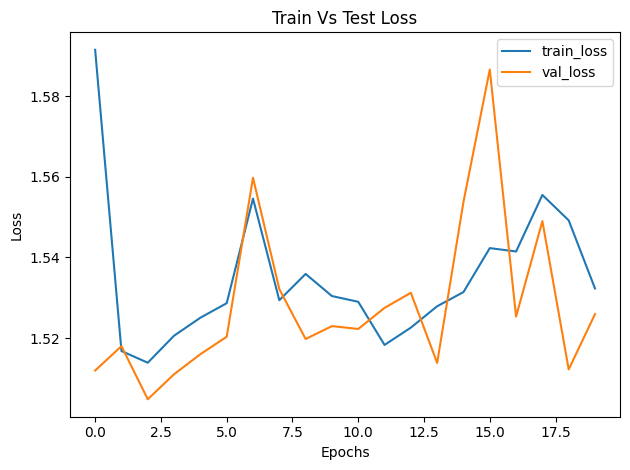

In [23]:
plt.plot(np.array(TRAIN_LOSS), label = 'train_loss')
plt.plot(np.array(VAL_LOSS), label = 'val_loss')
plt.title('Train Vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

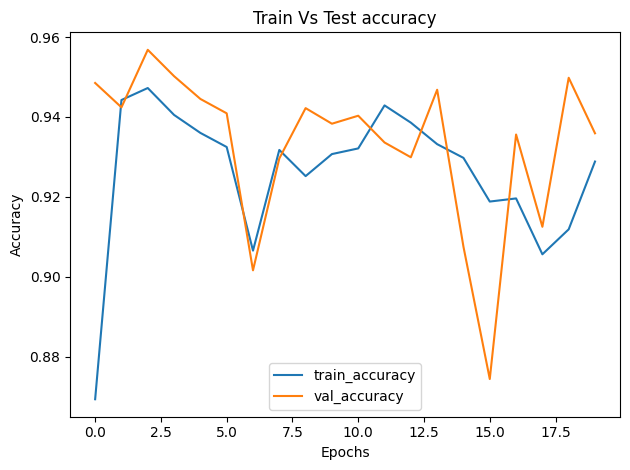

In [24]:
plt.plot(np.array(TRAIN_ACC), label = 'train_accuracy')
plt.plot(np.array(VAL_ACC), label = 'val_accuracy')
plt.title('Train Vs Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#####Evaluation the model

In [27]:
# Do the evaluation with respect to Train dataset
train_labels  = []
train_predict = []

for train_data, train_label in train_loader:
  # Connect GPU
  train_label = train_label.long()
  train_data  = train_data.to(device)
  train_label = train_label.to(device)

  train_predicted = model(train_data)
  train_predicted = torch.argmax(train_predicted.cpu(), 1).flatten().detach().numpy()

  train_labels.extend(train_label.cpu().flatten().detach().numpy())
  train_predict.extend(train_predicted)

########################
#       Display        #
########################

print("ACCURACY  # {}".format(accuracy_score(train_labels, train_predict)),'\n')
print("PRECISION # {}".format(precision_score(train_labels, train_predict, average = 'macro')),'\n')
print("RECALL    # {}".format(recall_score(train_labels, train_predict, average = 'macro')),'\n')
print("F1_SCORE  # {}".format(f1_score(train_labels, train_predict, average = 'macro')))

ACCURACY  # 0.9318333333333333 

PRECISION # 0.9358536707041754 

RECALL    # 0.9312359260850839 

F1_SCORE  # 0.9318428899742157


In [29]:
# Do the evaluation with respect to Train dataset
test_labels  = []
test_predict = []

for test_data, test_label in test_loader:
  # Connect GPU
  test_label = test_label.long()
  test_data  = test_data.to(device)
  test_label = test_label.to(device)

  test_predicted = model(test_data)
  test_predicted = torch.argmax(test_predicted.cpu(), 1).flatten().detach().numpy()

  test_labels.extend(test_label.cpu().flatten().detach().numpy())
  test_predict.extend(test_predicted)

########################
#       Display        #
########################

print("ACCURACY  # {}".format(accuracy_score(test_labels, test_predict)),'\n')
print("PRECISION # {}".format(precision_score(test_labels, test_predict, average = 'macro')),'\n')
print("RECALL    # {}".format(recall_score(test_labels, test_predict, average = 'macro')),'\n')
print("F1_SCORE  # {}".format(f1_score(test_labels, test_predict, average = 'macro')))

ACCURACY  # 0.9359 

PRECISION # 0.9404120877430702 

RECALL    # 0.9351840557645781 

F1_SCORE  # 0.9362062476301505
